# Анализ домов отправленных под реновацию

In [3]:
import warnings
warnings.simplefilter("ignore", Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm_notebook
import datetime
import time
%matplotlib inline

### Памятка

**data** - необработанные данные 33к жилых домов

**dataClarified** - данные домов из выделеных районов

**X** - data без ненужных признаков

**X1** - X с классами реновации и данными нужного тип

**renv** - дома попавшие под программу реновации

**Z** - нормарированная матрица X1 без классов

**y** - классы

**X1_w_address** - X1 с адресами

**X1_sorted** - X1 с адресами отсортированная по *area_nonli*

**min5service** - данные о 5-минутной достпности о домах из выдленых районов

In [4]:
data = pd.read_csv("reformagkh.csv")

In [5]:
data.head()

,X,Y,field_1,lat,lon,house_id,address,year,lastupdate,servicedat,...,cadno,energy_cla,blag_playg,blag_sport,blag_other,other,bldng_type,levels_int,year_int,type
0,407503.733246,6.186962e+06,0,55.817724,37.523465,7840062,"г. Москва, ул. Академическая Б., д. 4",1959,25.12.2015 в 12:07,01.04.2010,...,NaN,Не присвоен,Не имеется,Не имеется,Не имеется,Не имеется,NaN,8.0,1959.0,NaN
1,407524.379896,6.187033e+06,1,55.818372,37.523770,7840091,"г. Москва, ул. Академическая Б., д. 6, к. 1",1959,25.12.2015 в 12:07,01.04.2010,...,NaN,Не присвоен,Не имеется,Не имеется,Не имеется,Не имеется,khrushev,5.0,1959.0,khrushev
2,407586.434664,6.187039e+06,2,55.818437,37.524758,7840108,"г. Москва, ул. Академическая Б., д. 6, к. 2",1965,25.12.2015 в 12:08,01.04.2010,...,NaN,Не присвоен,Не имеется,Не имеется,Не имеется,Не имеется,khrushev,5.0,1965.0,khrushev
3,407677.777355,6.187043e+06,3,55.818488,37.526214,7840136,"г. Москва, ул. Академическая Б., д. 8, к. 1",1957,25.12.2015 в 12:08,01.04.2010,...,NaN,Не присвоен,Не имеется,Не имеется,Не имеется,Не имеется,khrushev,5.0,1957.0,khrushev
4,407594.917132,6.187093e+06,4,55.818923,37.524875,7840164,"г. Москва, ул. Академическая Б., д. 8, к. 2",1960,25.12.2015 в 12:08,01.04.2010,...,NaN,Не присвоен,Не имеется,Не имеется,Не имеется,Не имеется,khrushev,5.0,1960.0,khrushev


## Сравнение данных по 5 выбранным районам и всем домам в Москве

In [6]:
types = data["type"]

In [7]:
types.unique()

array([nan, 'khrushev', 'mod_ec', 'brezhnev', 'stl', 'prestl', 'prerev',
       'mod_prem', 'low_l', 'ind_pr_l'], dtype=object)

In [8]:
from collections import Counter

In [9]:
def draw_pie(types):
    types_counter = Counter(types)
    explode = []
    fig1, ax1 = plt.subplots()
    for key in types_counter.keys():
        if key == "khrushev":
            explode.append(0.2)
        else: 
            explode.append(0)
    ax1.pie([types_counter[key] for key in types_counter.keys()], 
            explode = explode,
            labels = types_counter.keys(), 
            colors=[cm.Set2(20*i) for i in range(len(types_counter))],
            shadow=True,
            pctdistance=0.7,
            labeldistance=1.2,
            autopct='%1.1f%%',
            radius=2, );

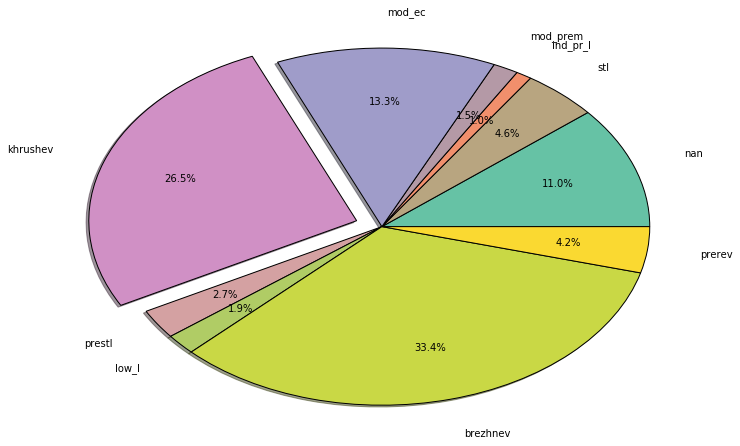

In [10]:
draw_pie(types)

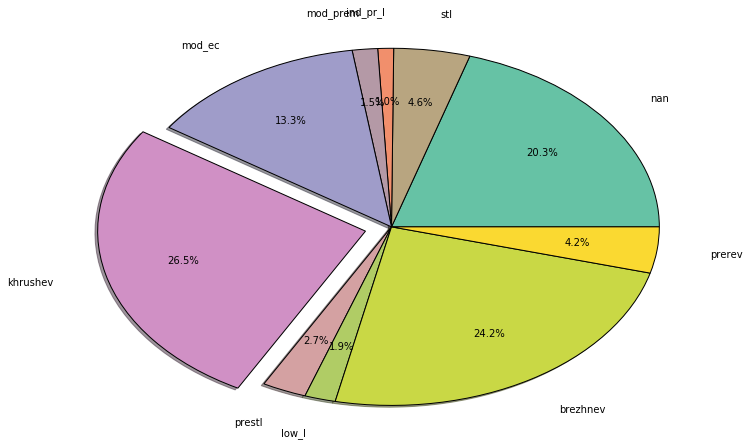

In [11]:
draw_pie(data["bldng_type"])

Видно, что в bldng_type часть брежневок ушла в nan, а все остальное осталось почти неизменным, поэтому мы можем избавится от этого признака в силу его схожести с type

In [12]:
dataClarified = pd.read_csv("houses_5_pol.csv", sep=";")

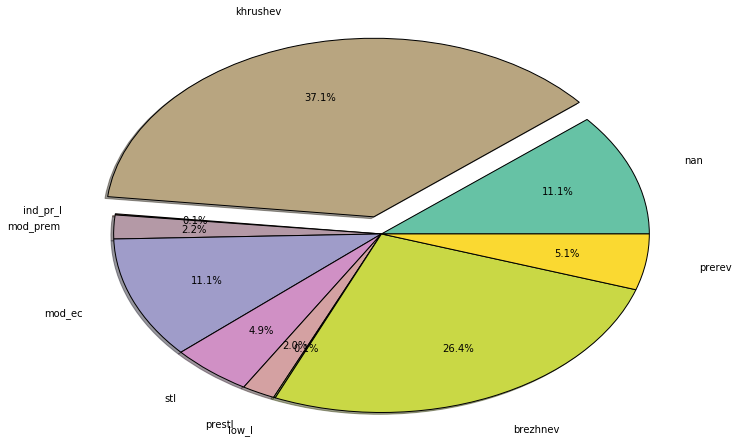

In [13]:
draw_pie(dataClarified["type"])

Сравним численные признаки(например год и площадь), чтобы быть еще уверенее что выборка репрезентативна

In [14]:
data["year_int"].describe()

count    31824.000000
mean      1969.745318
std         39.110425
min          5.000000
25%       1960.000000
50%       1968.000000
75%       1982.000000
max       6796.000000
Name: year_int, dtype: float64

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go

In [64]:
histAll = go.Histogram(
    x=data["year_int"], 
    xbins={
        "start": 1850, 
        "end": 2100
    },
    name="All buildings"
)

histClarified = go.Histogram(
    x=dataClarified["year_int"], 
    xbins={
        "start": 1850, 
        "end": 2100
    },
    name="Clarified buildings"
)
hists = [histAll, histClarified]

layout = go.Layout(
    title='Buildings year distrubution',
    xaxis=dict(
        title='Years'
    ),
    yaxis=dict(
        title='Count'
    ),
    bargap=0.2,
    bargroupgap=0.1
)
fig = go.Figure(data=hists, layout=layout)
py.iplot(fig)

Посмотрим на другие признаки и определим, какие из них катеориальные а какие численные

In [17]:
for feature in data.columns:
    print(feature)
    print(data[feature].head())
    print()

X
0    407503.733246
1    407524.379896
2    407586.434664
3    407677.777355
4    407594.917132
Name: X, dtype: float64

Y
0    6.186962e+06
1    6.187033e+06
2    6.187039e+06
3    6.187043e+06
4    6.187093e+06
Name: Y, dtype: float64

field_1
0    0
1    1
2    2
3    3
4    4
Name: field_1, dtype: int64

lat
0    55.817724
1    55.818372
2    55.818437
3    55.818488
4    55.818923
Name: lat, dtype: float64

lon
0    37.523465
1    37.523770
2    37.524758
3    37.526214
4    37.524875
Name: lon, dtype: float64

house_id
0    7840062
1    7840091
2    7840108
3    7840136
4    7840164
Name: house_id, dtype: int64

address
0          г. Москва, ул. Академическая Б., д. 4
1    г. Москва, ул. Академическая Б., д. 6, к. 1
2    г. Москва, ул. Академическая Б., д. 6, к. 2
3    г. Москва, ул. Академическая Б., д. 8, к. 1
4    г. Москва, ул. Академическая Б., д. 8, к. 2
Name: address, dtype: object

year
0    1959
1    1959
2    1965
3    1957
4    1960
Name: year, dtype: object

lastupda

In [18]:
print("In emergency state among all buildings: ", len(data[data["avar"] == "Да"]))
print("In emergency state among clarified buildings: ", len(dataClarified[dataClarified["avar"] == "Да"]))

In emergency state among all buildings:  56
In emergency state among clarified buildings:  2


In [19]:
data["blag_playg"].unique()

array(['Не имеется', 'Имеется', 'Не заполнено'], dtype=object)

In [20]:
def checkCategories(feature, data):
    print(feature)
    unique = data[feature].unique()
    print("Categories: ", unique)
    
    for category in unique:
        print(category + ": ", len(data[data[feature] == category]))
    print()

In [22]:
checkCategories("energy_cla", data)
checkCategories("blag_playg", data)
checkCategories("blag_sport", data)

energy_cla
Categories:  ['Не присвоен' 'B' 'Не заполнено' 'C' 'D' 'E' 'A' 'B++' 'B+']
Не присвоен:  16301
B:  1381
Не заполнено:  6164
C:  1786
D:  2880
E:  3223
A:  812
B++:  200
B+:  213

blag_playg
Categories:  ['Не имеется' 'Имеется' 'Не заполнено']
Не имеется:  11354
Имеется:  14349
Не заполнено:  7257

blag_sport
Categories:  ['Не имеется' 'Не заполнено' 'Имеется']
Не имеется:  21931
Не заполнено:  7479
Имеется:  3550



In [23]:
# Сравнение признаков bldng_type и type на равенство
for i in tqdm_notebook(range(data.shape[0])):
    dispairities = []
    row = data.iloc[i]
    if row["bldng_type"] != row["type"]:
        dispairities.append(row["house_id"])
print(dispairities)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



[8226994]


In [63]:
def diffHist(feature):
    histAll = go.Histogram(
        x=data[feature], 
        autobiny=True,
        name="All buildings"
    )

    histClarified = go.Histogram(
        x=dataClarified[feature], 
        autobiny=True,
        name="Clarified buildings"
    )
    hists = [histAll, histClarified]

    layout = go.Layout(
        title='Buildings ' + feature + ' distrubution',
        xaxis=dict(
            title=feature
        ),
        yaxis=dict(
            title='Count'
        ),
        bargap=0.2,
        bargroupgap=0.1
    )
    fig = go.Figure(data=hists, layout=layout)
    return fig

In [25]:
fig = diffHist("area")
fig["data"][0]["xbins"] = {
    "start": 0,
    "end": 40000,
    "size": 1000
}
fig["data"][1]["xbins"] = {
    "start": 0,
    "end": 40000,
    "size": 1000
}


py.iplot(fig)

## Предобработка данных

Избавимся от не нужный признаков

In [26]:
def get_rid_of_shitty_features(data):
    temp = data.columns[11:]
    temp = [i for i in temp if i not in ["capfond","room_count", "mgmt_compa", "mgmt_com_1", "levels_max", "levels_min", "room_cou_1", "room_cou_2", "cadno", "blag_other", "other", "bldng_type"]]
    features = temp + ["house_id"] + ["servicedat"]
    return data[features]

In [27]:
X = get_rid_of_shitty_features(data)
X.head(2)

,house_type,avar,doors,area,area_live,area_nonli,area_gen,area_land,area_park,energy_cla,blag_playg,blag_sport,levels_int,year_int,type,house_id,servicedat
0,Многоквартирный дом,Нет,4,9597.70,8004.30,1593.40,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,8.0,1959.0,NaN,7840062,01.04.2010
1,Многоквартирный дом,Нет,3,4688.10,3722.90,965.20,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,5.0,1959.0,khrushev,7840091,01.04.2010


Чтобы представить даты как численные признаки переведем их в unix timestamp

In [28]:
# servicedat to Unix timestamp
def data2timestamp(data):
    feature = "servicedat"
    if feature not in data:
        print("No servicedat feature")
        return
    
    serviceDates = list(data[feature])
    temp = []
    for date in serviceDates:
        if date != "Не заполнено":
            date = date.split(".")
            date = datetime.datetime(int(date[2]), int(date[1]), int(date[0]))
            date = time.mktime(date.timetuple())
        temp.append(date)

    serviceDates = temp
    data["servicedatUnix"] = serviceDates

data2timestamp(X)

try:
    del X["servicedat"]
except KeyError:
    print("No servicedat feature to delete")

In [29]:
X.head(2)

,house_type,avar,doors,area,area_live,area_nonli,area_gen,area_land,area_park,energy_cla,blag_playg,blag_sport,levels_int,year_int,type,house_id,servicedatUnix
0,Многоквартирный дом,Нет,4,9597.70,8004.30,1593.40,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,8.0,1959.0,NaN,7840062,1.27007e+09
1,Многоквартирный дом,Нет,3,4688.10,3722.90,965.20,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,5.0,1959.0,khrushev,7840091,1.27007e+09


Используем следующие утилиты для отчиски данных

In [30]:
# Checks if cell is numerical data 
def is_number(string):
    try:
        float(string)
    except ValueError:
        return False
    if np.isnan(float(string)):
        return False
    return True

def is_feature_numeric(feature, data):
    return is_number(data[feature][0])

# Changes all nan for mean for current feature
def nan2mean(feature, data):
    feature_list = list(data[feature])
    mean = int(np.mean([float(i) for i in feature_list if is_number(i)]))
    print(feature, mean)
    for i in range(len(feature_list)):
        if not is_number(feature_list[i]):
            feature_list[i] = mean
    data[feature] = feature_list
    

# all blanks to nan for current feature
def blank2nan(feature, data):
    column = data[feature]
    for row in range(len(column)):
        value = column[row]
        if value == 'Не заполнено' or value == 'Незаполнено':
            data.set_value(row, feature, np.NaN)

        
# make dummies from categorical features
def makeDummies(data):
    features = data.columns
    for feature in features:
        if not is_feature_numeric(feature, data):
            dummies = pd.get_dummies(data[feature]).rename(columns=lambda x: feature + "_is_" + str(x))
            data = pd.concat([data, dummies], axis=1)
            del data[feature]
    return data
            


# check if there any blanks in dataframe and print them
def check_for_nan(X):
    strset = set()
    for feature in tqdm_notebook(X.columns):
        for row in X[feature]:
            # We dont use is_number here because 
            # nan is not number too, and nan != nan
            # so when making set every nan is a different object
            try: 
                float(row)
            except:
                strset.add(row)
    print("Categories: ", strset)
    
    if X.isnull().any().any():
        print("NaN found")
    else:
        print("NaN not found")
    

In [31]:
features = X.columns

In [32]:
for feature in tqdm_notebook(X.columns):
    blank2nan(feature, X)

check_for_nan(X)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Categories:  {'Имеется', 'C', 'low_l', 'Не имеется', 'ind_pr_l', 'mod_prem', 'stl', 'B++', 'prestl', 'Жилой дом блокированной застройки', 'khrushev', 'Специализированный жилищный фонд', 'Нет', 'A', 'B+', 'brezhnev', 'Не присвоен', 'Многоквартирный дом', 'E', 'prerev', 'Да', 'D', 'mod_ec', 'B'}
NaN found


In [33]:
X.head(2)

,house_type,avar,doors,area,area_live,area_nonli,area_gen,area_land,area_park,energy_cla,blag_playg,blag_sport,levels_int,year_int,type,house_id,servicedatUnix
0,Многоквартирный дом,Нет,4,9597.70,8004.30,1593.40,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,8.0,1959.0,NaN,7840062,1.27007e+09
1,Многоквартирный дом,Нет,3,4688.10,3722.90,965.20,0.00,0.00,0.00,Не присвоен,Не имеется,Не имеется,5.0,1959.0,khrushev,7840091,1.27007e+09


In [34]:
for feature in tqdm_notebook(X.columns):
    if is_feature_numeric(feature, X):
        nan2mean(feature, X)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


doors 3
area 7769
area_live 6590
area_nonli 2452
area_gen 4008
area_land 1925
area_park 138
levels_int 9
year_int 1969
house_id 7902217
servicedatUnix 1305964459



Делаем dummies

In [35]:
X = makeDummies(X)

In [36]:
X.head(2)

,doors,area,area_live,area_nonli,area_gen,area_land,area_park,levels_int,year_int,house_id,...,blag_sport_is_Не имеется,type_is_brezhnev,type_is_ind_pr_l,type_is_khrushev,type_is_low_l,type_is_mod_ec,type_is_mod_prem,type_is_prerev,type_is_prestl,type_is_stl
0,4,9597.70,8004.30,1593.40,0.00,0.00,0.00,8.0,1959.0,7840062,...,1,0,0,0,0,0,0,0,0,0
1,3,4688.10,3722.90,965.20,0.00,0.00,0.00,5.0,1959.0,7840091,...,1,0,0,1,0,0,0,0,0,0


In [37]:
check_for_nan(X)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Categories:  set()
NaN not found


# МОЖНО КЛАССИФИЦИРОВАТЬ УРААААААЗыфшпрфщывалдоАЩФЫВДАЛФЫЛВОАЛФЫВА

In [38]:
renv = pd.read_csv("renovation.csv")

In [39]:
renv.head(2)

,field_1,lat,lon,house_id,bldng_type,levels_int,year_int,type,field_1_1,name,za,yavka,protiv
0,39,55.83183,37.53054,8151750,khrushev,5.0,1959.0,khrushev,21185,"Большая Академическая улица, дом 35А",92,60,14
1,40,55.83200,37.52986,8151767,khrushev,5.0,1960.0,khrushev,21214,"Большая Академическая улица, дом 35Б",97,67,5


In [40]:
type(renv["house_id"][0])

numpy.int64

In [41]:
set(type(i) for i in list(X["house_id"]))

{numpy.int64}

In [42]:
renv_houses = set(renv["house_id"])

In [43]:
def is_renv(data):
    X_houses = set(data["house_id"])
    X = data.set_index("house_id")
    X["is_renv"] = np.zeros((len(X), 1))
    X_houses = X_houses & renv_houses
    for house_id in X_houses:
        X.set_value(house_id, "is_renv", 1)
    return X

In [107]:
X1 = is_renv(X)

In [108]:
X1.head(2)

,doors,area,area_live,area_nonli,area_gen,area_land,area_park,levels_int,year_int,servicedatUnix,...,type_is_brezhnev,type_is_ind_pr_l,type_is_khrushev,type_is_low_l,type_is_mod_ec,type_is_mod_prem,type_is_prerev,type_is_prestl,type_is_stl,is_renv
house_id,,,,,,,,,,,,,,,,,,,,,
7840062,4,9597.70,8004.30,1593.40,0.00,0.00,0.00,8.0,1959.0,1.270066e+09,...,0,0,0,0,0,0,0,0,0,0.0
7840091,3,4688.10,3722.90,965.20,0.00,0.00,0.00,5.0,1959.0,1.270066e+09,...,0,0,1,0,0,0,0,0,0,0.0


In [109]:
from sklearn import preprocessing

# converts values to float for features from features 
def str2float(X, features):
    for feature in features:
        X[feature] = X[feature].apply(float)
        
def getZy(X1):
    features = [i for i in list(X1.columns) if "house_id" not in i and i != "is_renv" and i != "address"]
    str2float(X1, features)
    Z = X1[features]
    y = X1["is_renv"]
    return (Z, y)

In [111]:
X1_w_address = X1
X1_w_address["address"] = list(data["address"])
Z, y = getZy(X1_w_address)
scaler = preprocessing.StandardScaler()
Z = scaler.fit_transform(Z)

In [112]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

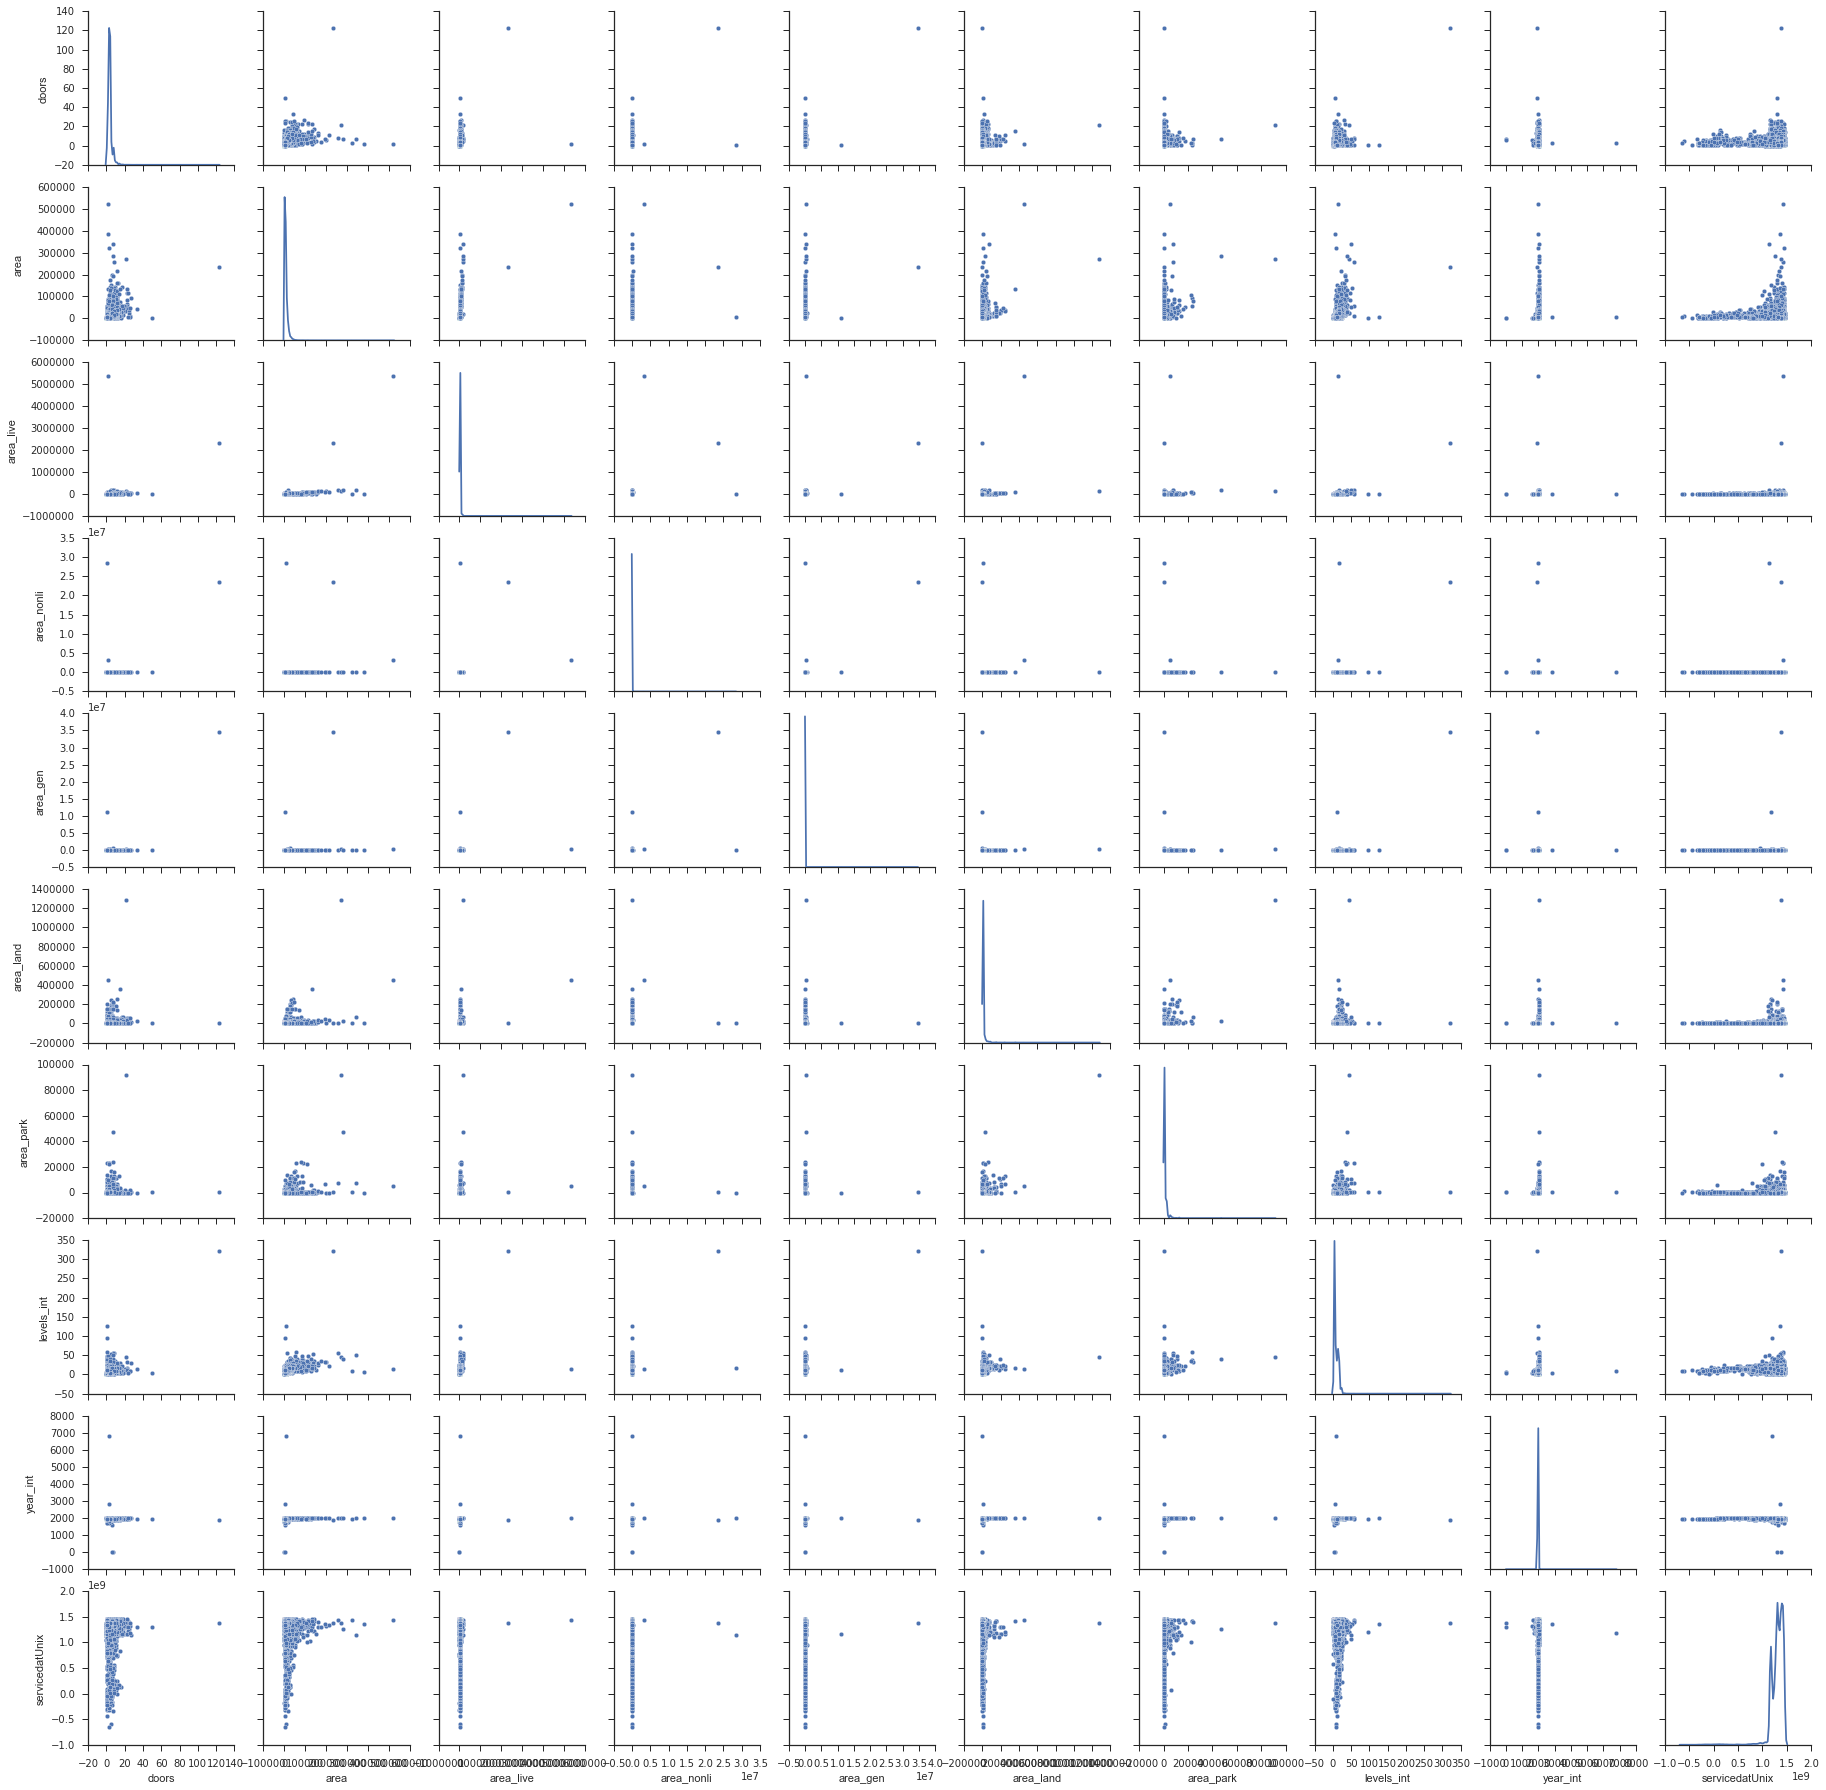

In [113]:
numerical_features = list(X1.columns)[:10]
sns.pairplot(X1[numerical_features], diag_kind="kde")

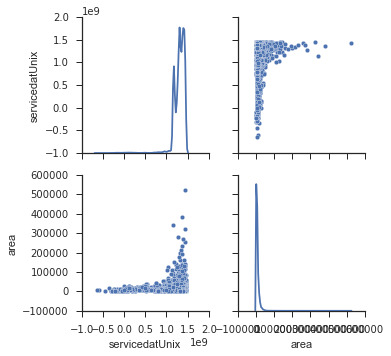

In [114]:
sns.pairplot(X1[numerical_features], diag_kind="kde", vars=["servicedatUnix", "area"])


In [115]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import eli5



def logReg(X, y, l, solver, c):
    lr = LogisticRegression(
        penalty=l, 
        C=c, 
        solver=solver, 
        class_weight="balanced",
        verbose = 1,
        random_state=42,
    )
        
#     lr.fit(X, y)
#     eli5.explain_weights(lr)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)
    lr.fit(X_train, y_train)
    print()
    print("f1_score: ", lr.score(X_test, y_test))
    return lr

In [116]:
lr = logReg(Z, y, l="l1", solver="liblinear", c=0.5)

[LibLinear]
f1_score:  0.843345469256


In [118]:
 eli5.explain_weights(lr, feature_names=[i for i in list(X1.columns) if "house_id" not in i and i != "address"][:-1], top=(40,40))

Weight?,Feature
+1.081,area_live
+0.855,type_is_khrushev
+0.681,doors
+0.445,blag_sport_is_Не имеется
+0.265,blag_sport_is_Имеется
+0.154,energy_cla_is_A
+0.132,servicedatUnix
+0.119,energy_cla_is_B
+0.109,energy_cla_is_E
+0.067,area_park


In [119]:
lr.coef_

array([[ 0.6811279 , -1.49273853,  1.08119021, -3.5247431 ,  0.        ,
        -0.91060137,  0.06669734, -2.22610922,  0.03804575,  0.13178705,
        -0.11240813, -0.23299437, -0.38408709, -0.05851755,  0.01238491,
         0.1537509 ,  0.11917133, -0.38954219, -0.20815034, -0.09067265,
         0.01107056,  0.10937644, -0.0595458 , -0.39930567, -0.36554961,
         0.26503601,  0.44522647, -1.27958444, -0.70263569,  0.85457037,
        -0.14457253, -0.35127168, -0.40483412, -0.66698734, -0.22917329,
        -0.03511785]])

In [120]:
lr = logReg(Z, y, l="l2", solver="lbfgs", c=10)


f1_score:  0.844154530744


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [121]:
 eli5.explain_weights(lr, feature_names=[i for i in list(X1.columns) if "house_id" not in i and i != "address"][:-1], top=(40,40))

Weight?,Feature
+2.137,area_live
+0.829,type_is_khrushev
+0.721,doors
+0.687,blag_sport_is_Не имеется
+0.458,blag_sport_is_Имеется
+0.205,area_park
+0.191,servicedatUnix
+0.158,energy_cla_is_A
+0.095,energy_cla_is_B
+0.033,year_int


In [122]:
lr = logReg(Z, y, l="l2", solver="sag", c=10)

max_iter reached after 2 seconds

f1_score:  0.847694174757


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


In [123]:
 eli5.explain_weights(lr, feature_names=[i for i in list(X1.columns) if "house_id" not in i and i != "address"][:-1], top=(40,40))

Weight?,Feature
+1.129,type_is_khrushev
+0.493,doors
+0.177,servicedatUnix
+0.135,energy_cla_is_A
+0.135,energy_cla_is_B
+0.111,blag_sport_is_Не имеется
+0.105,energy_cla_is_E
+0.059,type_is_stl
+0.054,blag_sport_is_Имеется
+0.042,area_park


Посмотрим на дома с большой нежилой площадью

In [124]:
X1_sorted_by_nonli = X1_w_address.sort_values("area_nonli", ascending=False)
X1_sorted_by_nonli[["address", "area_nonli"]] 

,address,area_nonli
house_id,,
8218518,"г. Москва, г. Троицк, б-р. Сиреневый, д. 11",28411220.2
9084016,"г. Москва, г. Зеленоград, д. 1306, к. 1",23463435.0
9068616,"г. Москва, г. Зеленоград, ул. Радио, д. 2307, ...",3165644.0
7618935,"г. Москва, наб. Академика Туполева, д. 15",135524.7
8663761,"г. Москва, ул. Михневская, д. 8",118679.1
8091210,"г. Москва, ш. Хорошевское, д. 12",71211.8
7550760,"г. Москва, ул. Мосфильмовская, д. 70",68884.2
7977692,"г. Москва, ул. Покрышкина, д. 8",53758.5
8000797,"г. Москва, ул. Татарская Б., д. 7",53120.0


In [125]:
X1_w_address.head()

,doors,area,area_live,area_nonli,area_gen,area_land,area_park,levels_int,year_int,servicedatUnix,...,type_is_ind_pr_l,type_is_khrushev,type_is_low_l,type_is_mod_ec,type_is_mod_prem,type_is_prerev,type_is_prestl,type_is_stl,is_renv,address
house_id,,,,,,,,,,,,,,,,,,,,,
7840062,4.0,9597.7,8004.3,1593.4,0.0,0.0,0.0,8.0,1959.0,1.270066e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Академическая Б., д. 4"
7840091,3.0,4688.1,3722.9,965.2,0.0,0.0,0.0,5.0,1959.0,1.270066e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Академическая Б., д. 6, к. 1"
7840108,3.0,1882.6,1882.6,0.0,0.0,0.0,0.0,5.0,1965.0,1.270066e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Академическая Б., д. 6, к. 2"
7840136,5.0,4480.6,4333.0,147.6,0.0,0.0,0.0,5.0,1957.0,1.270066e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Академическая Б., д. 8, к. 1"
7840164,5.0,4018.8,4018.8,0.0,0.0,0.0,0.0,5.0,1960.0,1.270066e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Академическая Б., д. 8, к. 2"


### Дома с самой большой нежилой площадью в Москве

г. Москва, г. Троицк, б-р. Сиреневый, д. 11 - выглядит как жилой дом( 28411220.2 )

г. Москва, г. Зеленоград, д. 1306, к. 1 - тоже жилой дом(23463435.0)

г. Москва, г. Зеленоград, ул. Радио, д. 23с7 площать с несколькими строениями, включая цвет торг(3165644.0)

г. Москва, наб. Академика Туполева, д. 15 - большой жилой дом(135524.7)

г. Москва, ул. Михневская, д. 8 - аналогично

г. Москва, ш. Хорошевское, д. 12 - аналогично

г. Москва, ул. Мосфильмовская, д. 70 - аналогично

## Классфикация 5 районов с признаками 5 минутной доступности

In [155]:
min5servicies = pd.read_csv("houses_5_pol_5_min_services.csv", sep=";")


In [156]:
min5servicies.head(2)

,ref_gkh_id,lat,lon,house_id,doors,room_count,room_cou_1,room_cou_2,area,area_live,...,5_Food_serv,5_Entertain,5_Finance,5_Car_serv,5_Outdoor_spaces,5_Prof_serv,5_Retail,5_Admin,5_Everyday_serv,5_Transport
0,16728,55.662334,37.605715,7579059,3,47,40,7,4484.80,2835.20,...,8,2,15,2,12,25,97,4,17,25
1,16729,55.660374,37.602049,8343061,5,239,РќРµ Р·Р°РїРѕР»РЅРµРЅРѕ,РќРµ Р·Р°РїРѕР»РЅРµРЅРѕ,11952.00,7802.00,...,6,3,8,3,8,20,69,4,14,15


In [157]:
min5servicies.columns

Index(['ref_gkh_id', 'lat', 'lon', 'house_id', 'doors', 'room_count',
       'room_cou_1', 'room_cou_2', 'area', 'area_live', 'area_nonli',
       'area_gen', 'area_land', 'area_park', 'levels_int', 'year_int', 'type',
       'hses_p5_id', '5_Art', '5_Edu', '5_Health', '5_Relig', '5_Admin_area',
       '5_Food_serv', '5_Entertain', '5_Finance', '5_Car_serv',
       '5_Outdoor_spaces', '5_Prof_serv', '5_Retail', '5_Admin',
       '5_Everyday_serv', '5_Transport'],
      dtype='object')

In [158]:
X1_w_5min = X1_w_address.loc[list(min5servicies["house_id"])]

In [159]:
min5feature = [feature for feature in list(min5servicies.columns) if "5" in feature and feature not in ['5_Art', '5_Relig', '5_Admin_area']][1:]

In [160]:
min5servicies.set_index("house_id", inplace=True)
min5servicies.head(2)

,ref_gkh_id,lat,lon,doors,room_count,room_cou_1,room_cou_2,area,area_live,area_nonli,...,5_Food_serv,5_Entertain,5_Finance,5_Car_serv,5_Outdoor_spaces,5_Prof_serv,5_Retail,5_Admin,5_Everyday_serv,5_Transport
house_id,,,,,,,,,,,,,,,,,,,,,
7579059,16728,55.662334,37.605715,3,47,40,7,4484.80,2835.20,1649.60,...,8,2,15,2,12,25,97,4,17,25
8343061,16729,55.660374,37.602049,5,239,РќРµ Р·Р°РїРѕР»РЅРµРЅРѕ,РќРµ Р·Р°РїРѕР»РЅРµРЅРѕ,11952.00,7802.00,РќРµР·Р°РїРѕР»РЅРµРЅРѕ,...,6,3,8,3,8,20,69,4,14,15


In [161]:
X1_w_5min.head()

,doors,area,area_live,area_nonli,area_gen,area_land,area_park,levels_int,year_int,servicedatUnix,...,type_is_ind_pr_l,type_is_khrushev,type_is_low_l,type_is_mod_ec,type_is_mod_prem,type_is_prerev,type_is_prestl,type_is_stl,is_renv,address
house_id,,,,,,,,,,,,,,,,,,,,,
7579059,3.0,4484.8,2835.2,1649.6,0.0,0.0,0.0,5.0,1955.0,1.435698e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"г. Москва, ул. Азовская, д. 3"
8343061,5.0,11952.0,7802.0,2452.0,4008.0,1925.0,138.0,12.0,1971.0,1.305964e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Азовская, д. 4"
7580908,3.0,2652.9,2340.1,312.8,0.0,0.0,0.0,5.0,1958.0,1.435698e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Азовская, д. 6, к. 1"
8038760,2.0,1797.7,1604.6,259.3,0.0,0.0,0.0,5.0,1959.0,1.435698e+09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Азовская, д. 6, к. 2"
8038764,1.0,2586.7,2586.7,0.0,0.0,0.0,0.0,9.0,1963.0,1.435698e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"г. Москва, ул. Азовская, д. 7, к. 1"


In [164]:
X1_w_5min = pd.concat((X1_w_5min, min5servicies[min5feature]), axis=1)

In [165]:
Z, y = getZy(X1_w_5min)

In [219]:
lr = logReg(Z, y, l="l1", solver="liblinear", c=10)

[LibLinear]
f1_score:  0.942857142857


In [220]:
 eli5.explain_weights(lr, feature_names=[i for i in list(X1_w_5min.columns) if "house_id" not in i and i != "address" and i != "is_renv"], top=(50,50))

Weight?,Feature
+4.860,type_is_low_l
+4.043,type_is_khrushev
+2.579,blag_sport_is_Не имеется
+2.248,type_is_prestl
+1.908,energy_cla_is_A
+1.503,blag_sport_is_Имеется
+0.513,doors
+0.154,5_Entertain
+0.136,energy_cla_is_D
+0.102,blag_playg_is_Имеется


In [228]:
X1_clarified = X1_w_address.loc[list(min5servicies.index)]

In [229]:
X1_clarified

(3850, 38)

In [230]:
Z, y = getZy(X1_clarified)

In [239]:
lr = logReg(Z, y, l="l1", solver="liblinear", c=0.5)

[LibLinear]
f1_score:  0.917748917749


In [240]:
 eli5.explain_weights(lr, feature_names=[i for i in list(X1_clarified.columns) if "house_id" not in i and i != "address" and i != "is_renv"], top=(50,50))

Weight?,Feature
+3.445,type_is_khrushev
+0.774,doors
+0.572,type_is_low_l
+0.567,energy_cla_is_A
+0.408,blag_sport_is_Не имеется
+0.391,blag_playg_is_Имеется
+0.001,area_live
+0.000,area_gen
+0.000,servicedatUnix
-0.000,area_park


In [241]:
renv.columns

Index(['field_1', 'lat', 'lon', 'house_id', 'bldng_type', 'levels_int',
       'year_int', 'type', 'field_1_1', 'name', 'za', 'yavka', 'protiv'],
      dtype='object')

In [245]:
renv[renv["yavka"]==0].describe()

,field_1,lat,lon,house_id,levels_int,year_int,field_1_1,za,yavka,protiv
count,4.000000,4.000000,4.000000,4.000000e+00,4.0,4.000000,4.000000,4.0,4.0,4.0
mean,17313.750000,55.771560,37.551482,7.921018e+06,4.5,1939.750000,39324.500000,0.0,0.0,0.0
std,11528.756405,0.091707,0.100325,1.415447e+05,1.0,22.677081,15348.002031,0.0,0.0,0.0
min,1048.000000,55.667340,37.457130,7.819518e+06,3.0,1911.000000,18126.000000,0.0,0.0,0.0
25%,14533.750000,55.708845,37.468785,7.849244e+06,4.5,1927.500000,33622.500000,0.0,0.0,0.0
50%,20028.500000,55.779695,37.552045,7.867061e+06,5.0,1943.000000,42877.000000,0.0,0.0,0.0
75%,22808.500000,55.842410,37.634743,7.938836e+06,5.0,1955.250000,48579.000000,0.0,0.0,0.0
max,28150.000000,55.859510,37.644710,8.130433e+06,5.0,1962.000000,53418.000000,0.0,0.0,0.0


In [246]:
renv.head()

,field_1,lat,lon,house_id,bldng_type,levels_int,year_int,type,field_1_1,name,za,yavka,protiv
0,39,55.83183,37.53054,8151750,khrushev,5.0,1959.0,khrushev,21185,"Большая Академическая улица, дом 35А",92,60,14
1,40,55.83200,37.52986,8151767,khrushev,5.0,1960.0,khrushev,21214,"Большая Академическая улица, дом 35Б",97,67,5
2,41,55.83220,37.52921,8100349,khrushev,5.0,1961.0,khrushev,21243,"Большая Академическая улица, дом 35В",78,63,31
3,42,55.83254,37.53092,8151774,khrushev,5.0,1961.0,khrushev,21272,"Большая Академическая улица, дом 37",97,68,6
4,45,55.83317,37.53167,8151785,khrushev,5.0,1961.0,khrushev,21301,"Большая Академическая улица, дом 39А",93,52,10


In [249]:
renv["yavka"].describe()

count    4409.000000
mean       70.789975
std         9.642916
min         0.000000
25%        65.000000
50%        71.000000
75%        76.000000
max       100.000000
Name: yavka, dtype: float64

In [288]:
rennovation = pd.read_csv("rennovation.csv")

In [290]:
rennovation.head(2)

,polygon,unom,date,lat,lon,za,protiv,yavka,area_name,district_name,name,updated_at,status,unom_type
0,"{'type': 'Polygon', 'coordinates': [[[55.72058...",12107,1496406919,55.720283,37.410252,76.0,24.0,41.0,Можайский,ЗАО,"улица Кубинка, дом 12, корпус 3",2.06,in_list,1.0
1,"{'type': 'Polygon', 'coordinates': [[[55.72264...",12121,1496406919,55.722354,37.410762,81.0,19.0,33.0,Можайский,ЗАО,"улица Кубинка, дом 18, корпус 5",2.06,in_list,1.0


In [302]:
right_rennovation = pd.DataFrame(columns=list(rennovation.columns))

In [303]:
buildings = list(rennovation["unom"].unique())

In [305]:
rows = []
for building in tqdm_notebook(buildings):
    temp = rennovation[rennovation["unom"] == building].sort_values("yavka", ascending=False)
    top_row = temp.iloc[0]
    rows.append(top_row)

    
    
right_rennovation = pd.concat((right_rennovation, pd.DataFrame(rows, columns=list(rennovation.columns))))

right_rennovation.head(2)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


,polygon,unom,date,lat,lon,za,protiv,yavka,area_name,district_name,name,updated_at,status,unom_type
59098,"{'type': 'Polygon', 'coordinates': [[[55.72058...",12107,1497530145,55.720283,37.410252,74.0,26.0,64.0,Можайский,ЗАО,"улица Кубинка, дом 12, корпус 3",15.06,in_list,1.0
59099,"{'type': 'Polygon', 'coordinates': [[[55.72264...",12121,1497530145,55.722354,37.410762,78.0,22.0,64.0,Можайский,ЗАО,"улица Кубинка, дом 18, корпус 5",15.06,in_list,1.0


In [307]:
right_rennovation.to_csv("right_rennovation.csv")

In [308]:
right_rennovation = pd.read_csv("right_rennovation_with_house_id.csv")

In [309]:
right_rennovation.head()

,field_1,lat,lon,house_id,address,year,lastupdate,servicedat,serie,house_type,...,lon_1,za,protiv,yavka,area_name,district_n,name,updated_at,status,unom_type
0,39,55.83183,37.53054,8151750,"г. Москва, ул. Академическая Б., д. 35 ""А""",1959,24.11.2015 в 20:21,Не заполнено,I-511,Многоквартирный дом,...,37.53058,88.0,12.0,60.0,Коптево,САО,"Большая Академическая улица, дом 35А",14.06,in_list,1.0
1,40,55.83200,37.52986,8151767,"г. Москва, ул. Академическая Б., д. 35 ""Б""",1960,24.11.2015 в 20:20,Не заполнено,I-511,Многоквартирный дом,...,37.52991,95.0,5.0,67.0,Коптево,САО,"Большая Академическая улица, дом 35Б",13.06,in_list,1.0
2,41,55.83220,37.52921,8100349,"г. Москва, ул. Академическая Б., д. 35В",1961,24.11.2015 в 20:18,Не заполнено,I-511,Многоквартирный дом,...,37.52926,74.0,26.0,63.0,Коптево,САО,"Большая Академическая улица, дом 35В",15.06,in_list,1.0
3,42,55.83254,37.53092,8151774,"г. Москва, ул. Академическая Б., д. 37",1961,24.11.2015 в 20:17,Не заполнено,I-510,Многоквартирный дом,...,37.53088,96.0,4.0,68.0,Коптево,САО,"Большая Академическая улица, дом 37",15.06,in_list,1.0
4,45,55.83317,37.53167,8151785,"г. Москва, ул. Академическая Б., д. 39А",1961,24.11.2015 в 20:15,Не заполнено,I-510,Многоквартирный дом,...,37.53170,90.0,10.0,52.0,Коптево,САО,"Большая Академическая улица, дом 39А",9.06,in_list,1.0


In [310]:
right_rennovation.shape[0]

4409